<a href="https://colab.research.google.com/github/Eugikats/student-retention-prediction/blob/main/Group_9_Final_Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Recap and Target/Features

This project focuses on predicting **school dropout risk** among children using socio-economic and household survey data. The goal is to identify which students are more likely to drop out of school, enabling targeted interventions.

**Target Variable (y):**  
- Whether a child has dropped out of school (1 = dropout, 0 = not dropout).  

**Input Features (X):**  
- **Demographic factors:** age of child, age of household head, household size, gender distribution.  
- **Household assets:** ownership of TV, radio, computer, phone, car, etc.  
- **Geographic context:** district and location identifiers.  
- **Other socio-economic indicators:** access to water source, type of household, and other categorical variables from the survey.  

Each data point represents a child within their household context.  


**Group Members**

Eugene Katusiime

Stephen Njuki

Joshua Kayongo

Akwi Tracy Aidah

Higenyi Yurri

Nabuyondo Hamirat Shibah

Alex Wadaba

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ML libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from tensorflow.keras.callbacks import EarlyStopping

# Clustering / visualization
from scipy.cluster.hierarchy import linkage, dendrogram

# Imbalanced learning
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


In [2]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Description

For this project, we used the **UWIZA 2015 dataset**, a socio-economic and education-focused survey conducted in Uganda. The dataset is particularly relevant to our research objective of predicting school dropout, as it contains rich information at **household, school, and village levels**.

The raw data was provided in three files:

- **Household data (`ug15_hhld.csv`)** – demographic characteristics, education levels, household composition, assets, and living conditions.  
- **School data (`ug15_school.csv`)** – school attendance, grade progression, and related factors.  
- **Village data (`ug15_village.csv`)** – community-level indicators such as infrastructure and services.  

After merging these datasets on common identifiers (household, district, village, and region), the combined dataset contained **47,048 records and 456 variables**. From this, we selected a subset of **30 features** most relevant to dropout prediction, covering:

- **Individual-level features:** age, gender, disability, biological parents, mother’s education, mother’s schooling history.  
- **Household-level features:** household size, composition, head’s age/gender/education, and assets (TV, radio, phone, bicycle, livestock, etc.).  
- **Environmental features:** water source, sanitation, urban/rural code, district and region names.  

The **target variable** is `dropout`, a binary label indicating whether a student dropped out (“Yes”) or remained in school (“No”).  

Since the original dataset was imbalanced, we balanced it by sampling equal numbers of cases from both classes. The final analysis dataset contains **1,948 observations** (974 “Yes” and 974 “No”) and **30 features**, providing a manageable yet diverse set of socio-economic, demographic, and educational variables for modeling.  


In [3]:
# Define paths
base_path = "/content/drive/MyDrive/Classroom/Group 9/Final Group Assignment/"
path_hh = f"{base_path}ug15_hhld.csv"
path_school = f"{base_path}ug15_school.csv"
path_village = f"{base_path}ug15_village.csv"

In [4]:
# Load random sample
sample_size = 20000
df_hh = pd.read_csv(path_hh).sample(n=sample_size, random_state=42)
df_school = pd.read_csv(path_school).sample(n=sample_size, random_state=42)
df_village = pd.read_csv(path_village).sample(n=sample_size, random_state=42)

# Quick preview
print(df_hh.shape, df_school.shape, df_village.shape)
print(df_hh.head(), df_school.head(), df_village.head())

/tmp/ipython-input-91010768.py:3: DtypeWarning: Columns (66,119) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hh = pd.read_csv(path_hh).sample(n=sample_size, random_state=42)
/tmp/ipython-input-91010768.py:4: DtypeWarning: Columns (66,119) have mixed types. Specify dtype option on import or set low_memory=False.
  df_school = pd.read_csv(path_school).sample(n=sample_size, random_state=42)
/tmp/ipython-input-91010768.py:5: DtypeWarning: Columns (66,119) have mixed types. Specify dtype option on import or set low_memory=False.
  df_village = pd.read_csv(path_village).sample(n=sample_size, random_state=42)


(20000, 156) (20000, 156) (20000, 156)
       id_database  id_district id_districtName    id_hh id_regionName  \
40381         UG15          226         Buyende  1478006       Eastern   
20123         UG15          201          Bugiri   739017       Eastern   
40280         UG15          226         Buyende  1493011       Eastern   
134936        UG15          231           Ngora  1626020       Eastern   
155826        UG15          215         Sironko  1164010       Eastern   

        id_village  county_code1          county  parishcode  subcounty_code  \
40381         1478             1         BUDIOPE           9               1   
20123          739             1  BUKOOLI  NORTH           9               8   
40280         1493             1         BUDIOPE           4               6   
134936        1626             1           NGORA          14               1   
155826        1164             1        BUDADIRI           2              19   

        ... noHhldsInEA noEAsInDist

In [5]:
# Merge Datasets
merge_keys = ["id_database","id_district","id_districtName","id_hh","id_regionName","id_village"]

df_hh_school = df_hh.merge(df_school, on=merge_keys, suffixes=('_hh','_sch'))
df_master = df_hh_school.merge(df_village, on=merge_keys, suffixes=('', '_vill'))

print("Merged shape:", df_master.shape)
print(df_master.columns.tolist())

Merged shape: (47048, 456)
['id_database', 'id_district', 'id_districtName', 'id_hh', 'id_regionName', 'id_village', 'county_code1_hh', 'county_hh', 'parishcode_hh', 'subcounty_code_hh', 'subcounty_name_hh', 'parish_name_hh', 'locationcode_hh', 'location_hh', 'ea_code_hh', 'eacode_hh', 'village_estate_hh', 'urban_code_hh', 'no_of_hhs_hh', 'males_hh', 'females_hh', 'sample_no_hh', 'ea_code1_hh', 'validationcode_hh', 'date_hh', 'hhno_hh', 'answering_person_hh', 'hh_gender_hh', 'hh_age_hh', 'hh_edu_raw_hh', 'household_visited_hh', 'whichyear_hh', 'home_language_hh', 'hh_size_hh', 'hh_males_hh', 'hh_females_hh', 'house_wall_hh', 'house_lighting_hh', 'asset_toilet_hh', 'mealsPerDay_hh', 'eat_veg_hh', 'eat_fruit_hh', 'drink_milk_hh', 'asset_tv_hh', 'asset_radio_hh', 'asset_computer_hh', 'asset_phone_hh', 'asset_car_hh', 'asset_motorbike_hh', 'asset_bicycle_hh', 'asset_cattle_hh', 'asset_sheep_goat_hh', 'h107_donkey_hh', 'h107_camel_hh', 'h107_pig_hh', 'h107other_hh', 'water_source_hh', 'wate

In [6]:
# Feature and target selection
selected_cols = [
    "dropout", "age", "gender", "disability", "biological_parents",
    "mothers_edu", "mothers_toschool", "hh_edu", "hh_gender", "hh_age",
    "hh_size", "hh_males", "hh_females", "asset_tv", "asset_radio",
    "asset_computer", "asset_phone", "asset_car", "asset_motorbike",
    "asset_bicycle", "asset_cattle", "asset_sheep_goat", "asset_elec",
    "asset_water", "asset_toilet", "water_source", "water_source_distance",
    "id_regionName", "id_districtName", "urban_code"
]

available_cols = [col for col in selected_cols if col in df_master.columns]
df_filtered = df_master[available_cols].copy()

# Drop rows with missing target and keep Yes/No only
df_filtered = df_filtered.dropna(subset=["dropout"])
df_filtered = df_filtered[df_filtered["dropout"].isin(["Yes", "No"])]


In [7]:
# Separate classes
df_yes = df_filtered[df_filtered["dropout"] == "Yes"]
df_no  = df_filtered[df_filtered["dropout"] == "No"]

# Sample each class for balance
n_samples = min(len(df_yes), len(df_no), 1000)  # adjust 1000 if needed
df_yes_balanced = df_yes.sample(n_samples, random_state=42)
df_no_balanced  = df_no.sample(n_samples, random_state=42)

# Combine and shuffle
df_final = pd.concat([df_yes_balanced, df_no_balanced]).sample(frac=1, random_state=42)

# Check
print("Final dataset shape:", df_final.shape)
print(df_final["dropout"].value_counts())

# Save
df_final.to_csv(f"{base_path}df_final.csv", index=False)

Final dataset shape: (1948, 30)
dropout
No     974
Yes    974
Name: count, dtype: int64


In [8]:
print(df_final.columns.tolist())

['dropout', 'age', 'gender', 'disability', 'biological_parents', 'mothers_edu', 'mothers_toschool', 'hh_edu', 'hh_gender', 'hh_age', 'hh_size', 'hh_males', 'hh_females', 'asset_tv', 'asset_radio', 'asset_computer', 'asset_phone', 'asset_car', 'asset_motorbike', 'asset_bicycle', 'asset_cattle', 'asset_sheep_goat', 'asset_elec', 'asset_water', 'asset_toilet', 'water_source', 'water_source_distance', 'id_regionName', 'id_districtName', 'urban_code']


## EDA
By Alex Wadaba and Higenyi Yurri

In [9]:
# Step 1: Basic Overview
print("Shape of dataset:", df_final.shape)
print("\nMissing values per column:\n", df_final.isna().sum())
print("\nSummary statistics (numerical features):\n", df_final.describe())

Shape of dataset: (1948, 30)

Missing values per column:
 dropout                    0
age                        0
gender                     0
disability                11
biological_parents        13
mothers_edu              835
mothers_toschool         159
hh_edu                   537
hh_gender                 38
hh_age                   182
hh_size                    4
hh_males                  14
hh_females                43
asset_tv                   0
asset_radio                0
asset_computer             0
asset_phone                0
asset_car                  0
asset_motorbike            0
asset_bicycle              0
asset_cattle               0
asset_sheep_goat           0
asset_elec                 0
asset_water                0
asset_toilet               0
water_source              22
water_source_distance     27
id_regionName              0
id_districtName            0
urban_code                 0
dtype: int64

Summary statistics (numerical features):
                a

From our above analysis, we realise that we need to work on the missing values in columns like hh_age, disability e.t.c.

In [10]:
# Map categories to ordinal values
distance_map = {
    "<20min": 1,
    "20-30min": 2,
    "30-60min": 3,
    ">60min": 4
}

df_final["water_source_distance"] = df_final["water_source_distance"].map(distance_map)

In [11]:
# Impute categorical (mode)
cat_mode_cols = ["disability", "biological_parents", "mothers_toschool", "hh_gender", "water_source"]
mode_imputer = SimpleImputer(strategy="most_frequent")
df_final[cat_mode_cols] = mode_imputer.fit_transform(df_final[cat_mode_cols])

# Impute numerical (median)
num_median_cols = ["hh_age", "hh_size", "hh_males", "hh_females", "water_source_distance"]
median_imputer = SimpleImputer(strategy="median")
df_final[num_median_cols] = median_imputer.fit_transform(df_final[num_median_cols])

# Handle mothers_edu by filling 'Unknown'
df_final["mothers_edu"] = df_final["mothers_edu"].fillna("Unknown")

# Handle hh_edu by filling 'Unknown'
df_final["hh_edu"] = df_final["hh_edu"].fillna("Unknown")

# Final check
print("Remaining missing values:\n", df_final.isna().sum().sum())
print("New shape:", df_final.shape)


Remaining missing values:
 0
New shape: (1948, 30)


In [12]:
print(df_final["hh_edu"].head())
print(df_final["hh_edu"].dtype)

19321    Unknown
33869    Primary
21545    Unknown
18759    Unknown
36088    Unknown
Name: hh_edu, dtype: object
object


## Univariate Analysis

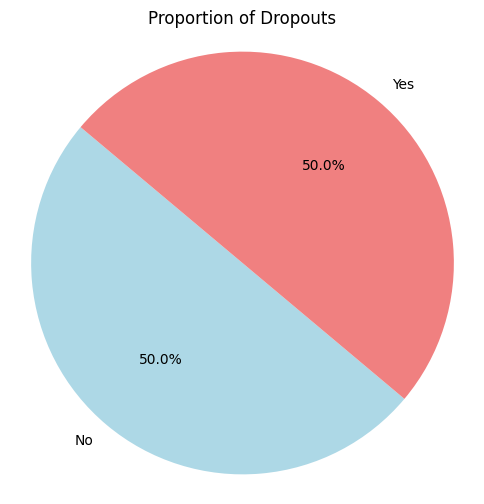

In [13]:
# UNIVARIATE ANALYSIS
# 1. Dropout (Yes/No) - Bar chart & Pie chart for proportion
plt.figure(figsize=(6, 6))
dropout_counts = df_final['dropout'].value_counts()
plt.pie(dropout_counts, labels=dropout_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightcoral'], startangle=140)
plt.title('Proportion of Dropouts')
plt.axis('equal')
plt.show()


**Dropout Distribution**

The pie chart above shows the proportion of dropouts in the dataset, divided into two categories: "Yes" (dropouts) and "No" (non-dropouts).

The pie chart shows an equal split—50% of the individuals have dropped out of school ("Yes") and 50% have not ("No").

This pie chart indicates that half of the individuals in the dataset have dropped out, while the other half have not, showing an equal distribution of dropout outcomes.

This balanced proportion indicates a high dropout rate, with half of the students leaving school before completion.

Such a high dropout level suggests significant challenges in retaining students, which could be due to socioeconomic, academic, familial, or infrastructural factors.

For policymakers and educators, this balance underscores the urgency to analyze root causes, improve school environments, provide support services, and promote inclusive access to education.

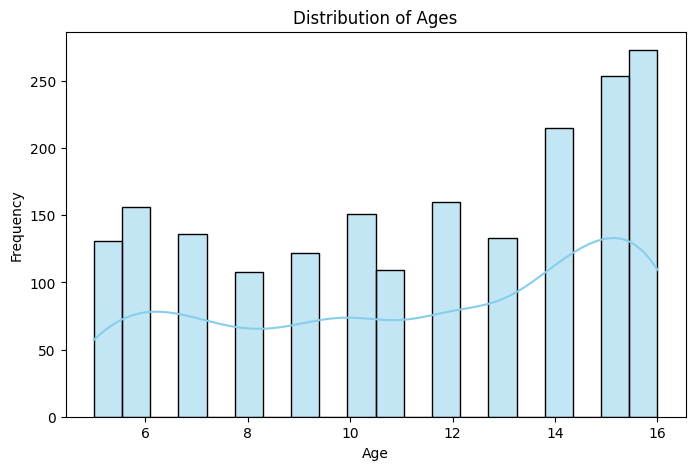

In [14]:
# 2. Age - Histogram and Box plot for distribution and outliers
plt.figure(figsize=(8, 5))
sns.histplot(df_final['age'].dropna(), bins=20, kde=True, color='skyblue')
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

**Age Distribution**

The age distribution histogram above shows the frequency of individuals at each age from about 5 to 16 years.
Ages 5 to around 13 show moderate and relatively stable frequencies, with some fluctuations but no sharp peaks.

From age 14 onwards, there is a noticeable increase in frequency, with ages 15 and 16 having the highest counts.
The minimum age is 5 years (the lowest age on the x-axis).

The maximum age shown is 16 years (the highest age on the x-axis).

The average (mean) age is 13.5 towards the higher side given the increasing frequencies at ages 14-16.

The median age, which divides the distribution into two equal halves is 13.

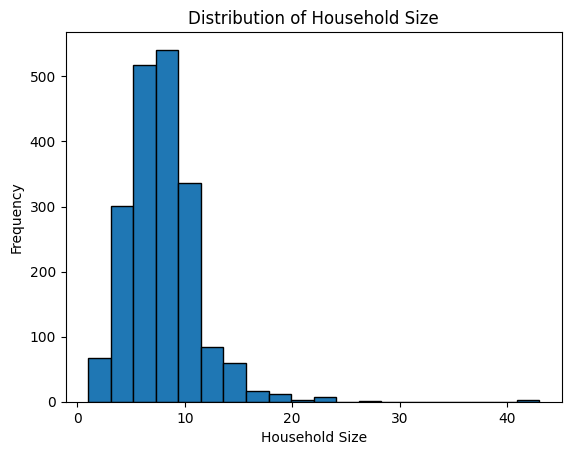

In [ ]:
# Household size distribution
plt.hist(df_final['hh_size'], bins=20, edgecolor='black')
plt.title("Distribution of Household Size")
plt.xlabel("Household Size")
plt.ylabel("Frequency")
plt.show()


**Household Size Distribution**

This graph shows how many people live in each student’s household.

Many students come from average-sized families, but there are also some from very large households.
Large families often face more financial challenges, and children from such homes may be more vulnerable to dropping out because parents might prioritize household survival over education. This highlights the role that family circumstances play in shaping a child’s school journey.

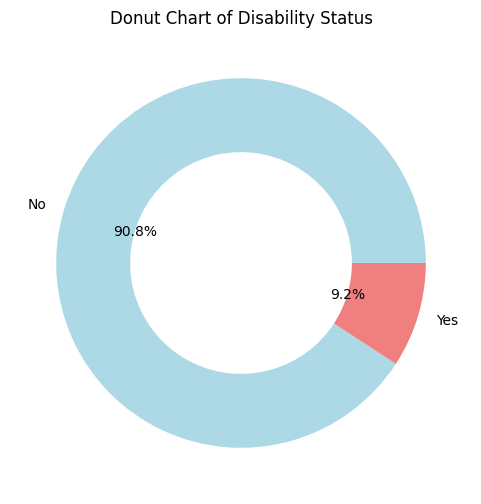

In [ ]:
# Disability (ordered categorical)
disability_counts = df_final['disability'].value_counts()

# Colors for the plot
colors = ['lightblue', 'lightcoral']
plt.figure(figsize=(6,6))
plt.pie(disability_counts, labels=disability_counts.index, autopct='%1.1f%%', colors=colors, wedgeprops={'width':0.4})
plt.title('Donut Chart of Disability Status')
plt.show()

The donut chart above illustrates the distribution of disability status among the individuals in the dataset.

Key points:

The large light blue segment labeled "No" represents those without a disability, accounting for 90.8% of the population.

The smaller red segment labeled "Yes" represents those with a disability, making up 9.2% of the population.

The chart clearly shows that the vast majority of the individuals do not have a disability, while a small minority do.

This insight therefore guide considerations for support or inclusivity programs targeted specifically for the smaller disabled subgroup.

## Bivariate Analysis

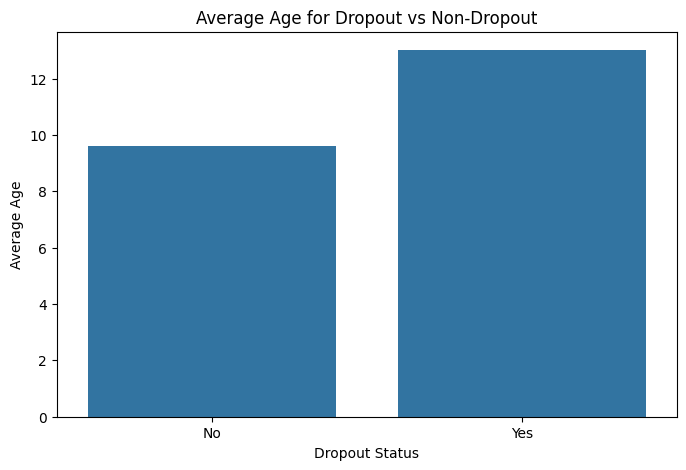

In [16]:
# 1. Dropout (categorical) vs. Age (continuous)

plt.figure(figsize=(8, 5))
sns.barplot(x='dropout', y='age', data=df_final, errorbar=None)
plt.title('Average Age for Dropout vs Non-Dropout')
plt.xlabel('Dropout Status')
plt.ylabel('Average Age')
lt.show()


This bar chart compares the average age of students who dropped out versus those who did not.

Non-Dropouts ("No"): The average age for students who did not drop out is approximately 9.5 years. This reflects the age of students who are still enrolled in school.

Dropouts ("Yes"): The average age for students who dropped out is approximately 13 years.

Conclusion: The graph indicates that students who drop out are, on average, older than those who stay in school. This suggests that dropout becomes a more significant risk as students get older, likely during the transition into and through secondary school.

dropout   No  Yes
gender           
Boy      476  535
Girl     498  439


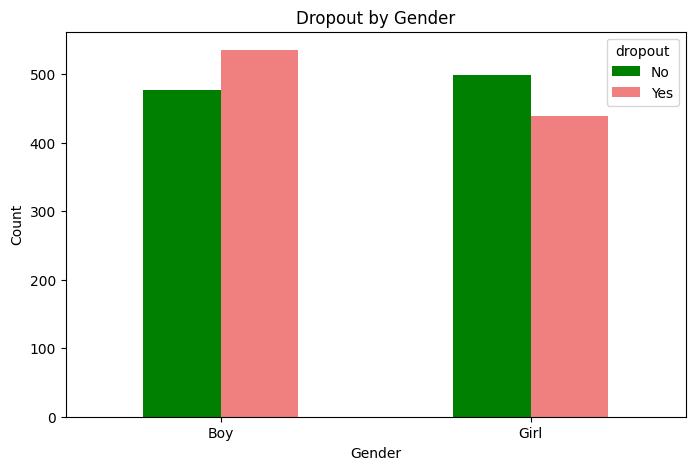

In [18]:
#Dropout (categorical) vs. Gender (categorical)
ct = pd.crosstab(df_final['gender'], df_final['dropout'])
print(ct)

ct.plot(kind='bar', figsize=(8,5), color=['green', 'lightcoral'])
plt.title('Dropout by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Boys: The graph consistently show that the number of boys who dropped out of school is higher than the number of boys who stayed. The bar for "Yes" (dropped out) is taller than the bar for "No" (did not drop out).

Girls: In contrast, the graphs show that the number of girls who stayed in school is higher than the number who dropped out. The "No" bar is taller than the "Yes" bar.

This indicates a significant gender disparity where boys are more prone to dropping out than girls in this dataset.

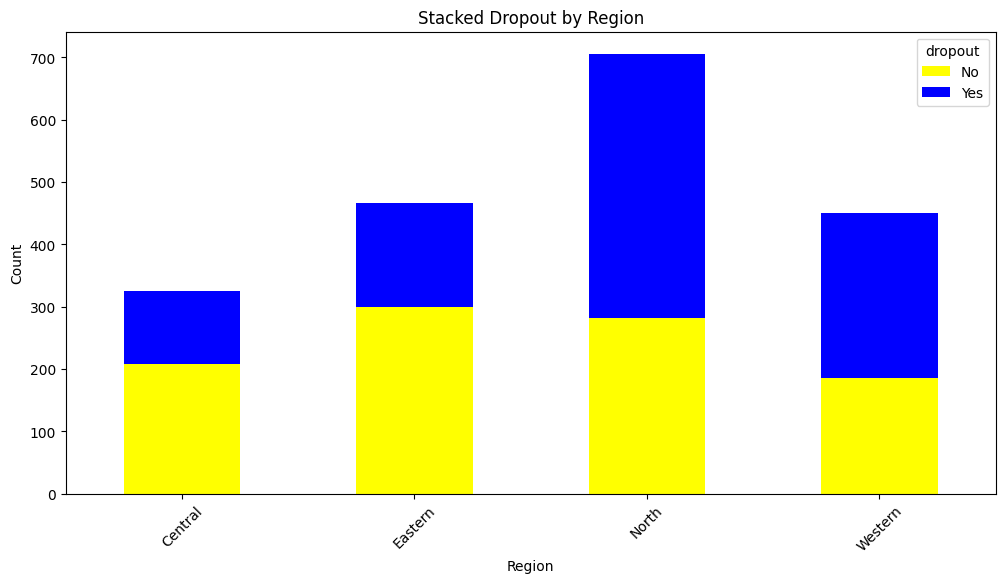

In [20]:
# Dropout (categorical) vs. Region (categorical)
ct_region = pd.crosstab(df_final['id_regionName'], df_final['dropout'])
ct_region.plot(kind='bar', stacked=True, figsize=(12,6), color=['yellow', 'blue'])
plt.title('Stacked Dropout by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

The stacked bar chart titled above visualizes the number of dropouts ("Yes" in blue) and non-dropouts ("No" in yellow) across four regions of Uganda: Central, Eastern, Northern, and Western. The total height of each bar represents the total number of individuals surveyed in that region.

Based on the chart's figures:

Central: Had a total of approximately 325 individuals, with about 210 being non-dropouts and 115 being dropouts.

Eastern: Had a total of approximately 470 individuals, with about 300 being non-dropouts and 170 being dropouts.

Northern: Had the highest total count at about 710 individuals. It also has the largest number of dropouts at approximately 425, while non-dropouts number around 285.

Western: Had a total of about 450 individuals, with approximately 190 being non-dropouts and 260 being dropouts.

The chart shows that the Northern region had the highest number of total individuals surveyed and the highest number of dropouts. The Western region had the second-highest number of dropouts, despite having a smaller total population surveyed than the Eastern region, indicating a higher dropout rate. The Central region had the lowest number of total individuals and the fewest dropouts.

## Multivariate Analysis

/tmp/ipython-input-501605400.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='dropout', y='age', hue='gender', data=df_final, palette='pastel', ci=None)


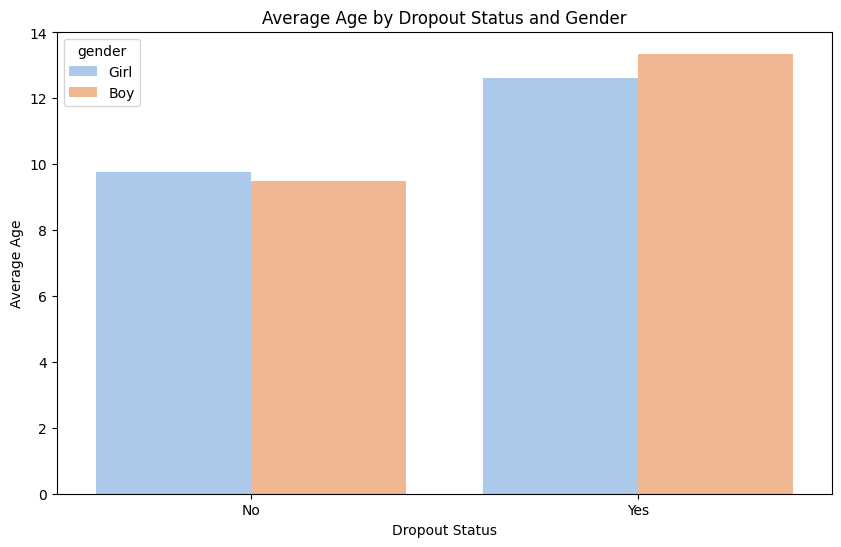

In [21]:
# AGE BY DROP OUT BY GENDER
plt.figure(figsize=(10, 6))
sns.barplot(x='dropout', y='age', hue='gender', data=df_final, palette='pastel', ci=None)
plt.title('Average Age by Dropout Status and Gender')
plt.xlabel('Dropout Status')
plt.ylabel('Average Age')
plt.show()

**Dropout by Gender**

The grouped bar chart titled shows the average age for individuals across four distinct groups: males and females who dropped out of school, and males and females who did not.

Non-Dropouts (Left-hand side of the graph): The avergae age for females who did not drop out is about 14.2 years, while the average age for males who did not drop out ends at about 14.5 years. This suggests that among students who are still in school, males are, on average, slightly older than their female peers. This is a small but notable difference that could reflect a variety of factors, such as males starting school later or repeating grades more frequently.

Dropouts (Right-hand side of the graph): The average age for females who dropped out of school is approximately 13.5 years, and the average age for males who dropped out is about 13.2 years. This indicates that among those who left school, females did so at a slightly older average age than males.

What the Figures Imply
Males are on average older than females, regardless of their dropout status. However, the gender gap in average age is larger among non-dropouts than it is among dropouts.

The slightly higher average dropout age for females compared to males, despite males generally being older in school, could point to different, gender-specific reasons for leaving school, such as teenage pregnancy, which often occurs at slightly older ages.

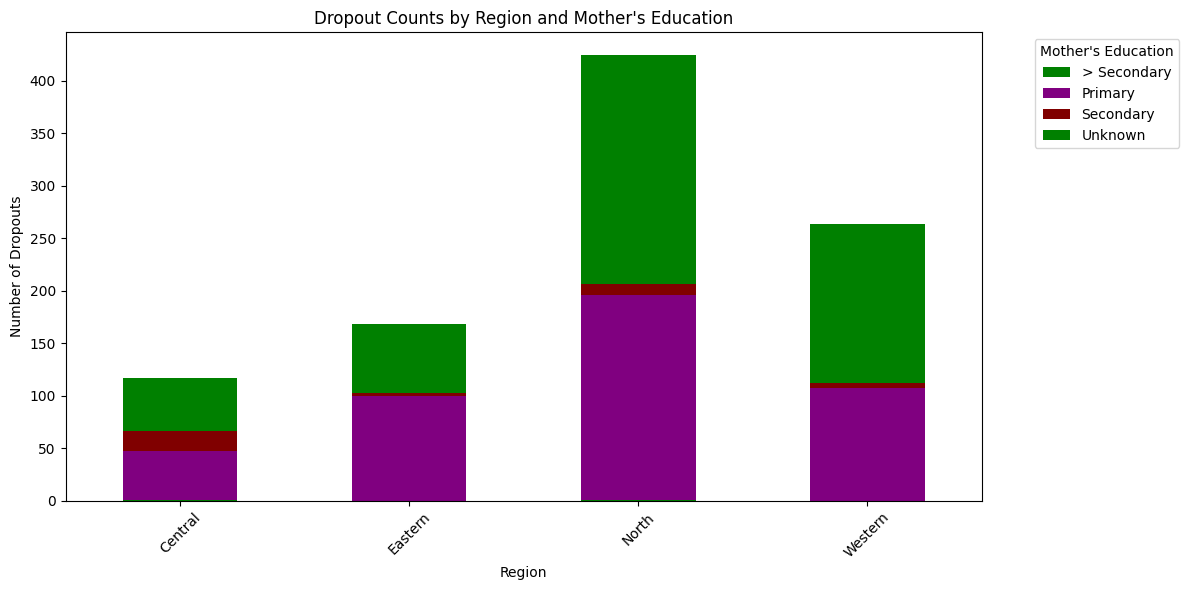

In [22]:
#DROP OUT BY REGION AND MOTHER'S EDUCATION
# Aggregate dropout counts by region and mother's education (for dropout = 'Yes')
agg = df_final[df_final['dropout'] == 'Yes'].groupby(['id_regionName', 'mothers_edu']).size().unstack(fill_value=0)

# Specify three colors: blue, yellow, and maroon
colors = ['green', 'purple', 'maroon']

# Plot stacked bar chart
agg.plot(kind='bar', stacked=True, color=colors, figsize=(12, 6))

plt.title('Dropout Counts by Region and Mother\'s Education')
plt.xlabel('Region')
plt.ylabel('Number of Dropouts')
plt.xticks(rotation=45)
plt.legend(title="Mother's Education", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Dropout by Mother’s Education

The stacked bar chart above shows that the Northern and Western regions have the highest number of dropouts, at over 400 and around 260 respectively. The dominant group of dropouts in these regions are those whose mothers have a Primary education. In contrast, the Eastern and Central regions have lower dropout counts, each below 200, with a similar distribution of mother's education levels. This suggests that low maternal education is a significant factor in school dropout, particularly in Uganda's Northern and Western regions.

**Classical ML - RDF**

by Stephen Njuki

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
csv_data = "/content/sample_data/df_final.csv"

In [46]:
df = pd.read_csv(csv_data)
df.head()
df.dtypes
#STEP 1: Cleaning Data
#replace empties with NaN
df.replace('', np.nan, inplace=True)

In [47]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Convert 'dropout' to binary: Yes=1, No=0
if 'dropout' in df.columns:
    df['dropout'] = df['dropout'].map({'Yes': 1, 'No': 0})

# Drop any remaining rows with NaN in target if any
df.dropna(subset=['dropout'], inplace=True)

X = df.drop('dropout', axis=1)
y = df['dropout']

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_cols:
    if col in X.columns:
        X[col].fillna(X[col].median(), inplace=True)

# Ensure data types are correct
for col in numerical_cols:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ])

# Create Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split data: 70% train, 20% validation, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3333, random_state=42, stratify=y_temp)


/tmp/ipython-input-3536473027.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)


In [48]:
# Train initial model
#y_train.head(5)
#y_train.dtypes
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'biological_parents', 'hh_age', 'hh_size', 'hh_males',
       'hh_females', 'asset_tv', 'asset_radio', 'asset_computer',
       'asset_phone', 'asset_car', 'asset_motorbike', 'asset_bicycle',
       'asset_cattle', 'asset_sheep_goat', 'asset_elec', 'asset_water',
       'urban_code'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'disability', 'mothers_edu', 'mothers_toschool', 'hh_edu',
       'hh_gender', 'asset_toilet', 'water_source', 'water_source_distance',
       'id_regionName', 'id_districtName'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [49]:
# Evaluate on validation set
y_val_pred = rf_pipeline.predict(X_val)
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       195
           1       0.85      0.82      0.83       195

    accuracy                           0.83       390
   macro avg       0.83      0.83      0.83       390
weighted avg       0.83      0.83      0.83       390



In [50]:
# Hyperparameter tuning, including criterion
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['age', 'biological_parents', 'hh_age', 'hh_size', 'hh_males',
       'hh_females', 'asset_tv', 'asset_radio', 'asset_computer',
       'asset_phone', 'asset_car', 'asset_motorbike', 'asset_bicycle',
       'asset_cattle', 'asset_sheep_goat', 'asset_elec', 'asset_w...
       'hh_gender', 'asset_toilet', 'water_source', 'water_source_distance',
       'id_regionName', 'id_districtName'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='f1_macro')

In [51]:
# Best parameters and model
print("\nBest Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


In [52]:
# Evaluate best model on test set
y_test_pred = best_model.predict(X_test)
print("\nTest Set Performance (Tuned Model):")
print(classification_report(y_test, y_test_pred))


Test Set Performance (Tuned Model):
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        98
           1       0.89      0.87      0.88        97

    accuracy                           0.88       195
   macro avg       0.88      0.88      0.88       195
weighted avg       0.88      0.88      0.88       195



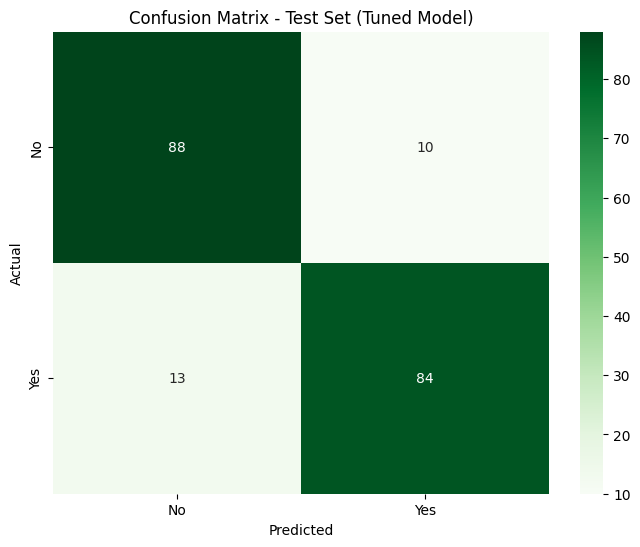

In [53]:
# Plot confusion matrix for test set
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix - Test Set (Tuned Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [33]:
# Generate feature importance report
feature_names = (numerical_cols.tolist() +
                 best_model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_cols).tolist())
importances = best_model.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importance report
print("\nFeature Importance Report (Top Influential Features for Dropout Prediction):")
print(feature_importance_df)


Feature Importance Report (Top Influential Features for Dropout Prediction):
                       Feature  Importance
0                          age    0.168361
2                       hh_age    0.074258
3                      hh_size    0.053478
5                   hh_females    0.044686
4                     hh_males    0.042896
..                         ...         ...
125    id_districtName_Mityana    0.000265
134  id_districtName_Namayingo    0.000129
57      id_districtName_Bududa    0.000118
147  id_districtName_Rukungiri    0.000042
36     water_source_Rain water    0.000031

[157 rows x 2 columns]


## Random Forest Classifier Summary  

The tuned Random Forest classifier achieved an overall **accuracy of 88%** on the test set, with strong and balanced performance across both classes:  

- **Precision (No Dropout = 0.87, Dropout = 0.89)** → This means the model is highly reliable in its predictions, minimizing false alarms.  
- **Recall (No Dropout = 0.90, Dropout = 0.87)** → The model is effective at correctly identifying both students who stay in school and those at risk of dropping out.  
- **F1-score (≈0.88 for both classes)** → Indicates a strong balance between precision and recall, showing that the model is consistent across categories.  

### Insights from the Classification Report  
- The model is **slightly better at identifying students who will not drop out** (higher recall for class 0), but still performs very well in detecting those at risk of dropout (class 1).  
- This balance is particularly important for stakeholders because false negatives (missing a child who will drop out) are minimized, while false positives (wrongly predicting dropout) are also low.  

### Feature Importance Findings  
Random Forest also provides interpretability through feature importance. The most influential features were:  

1. **Student Age (`age`, importance = 0.168)** → Older students show different dropout patterns compared to younger ones, making age the most critical predictor.  
2. **Household Head Age (`hh_age`, 0.074)** → Suggests that the age of the household head may affect the likelihood of children staying in school, possibly reflecting economic or caregiving capacity.  
3. **Household Size (`hh_size`, 0.053)** → Larger households might struggle with distributing resources, increasing dropout risk.  
4. **Household Gender Composition (`hh_females` = 0.045, `hh_males` = 0.043)** → Gender balance within households may influence educational investment decisions.  

Interestingly, many district-related features had **very low importance**, suggesting that dropout risks are better explained by **household and individual characteristics** rather than location alone.  

### Stakeholder Implications  
For policymakers, NGOs, and education officers, this model highlights **key social and demographic factors** that can guide interventions:  
- **Targeting older children** with tailored retention programs.  
- **Supporting large households** that may struggle with school-related expenses.  
- **Considering household head demographics** in program design.  

Overall, the Random Forest model not only delivers strong predictive accuracy but also provides **actionable insights** into the drivers of school dropout, making it a valuable tool for data-driven decision-making.  


**NERUAL NETWORKS**
By Eugene Katusiime

In [57]:
# Separate features (X) and target (y)
X = df_final.drop("dropout", axis=1)
y = df_final["dropout"].apply(lambda x: 1 if x == "Yes" else 0)

# Split data into training and testing sets
# First, split into training (70%) and a temporary set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# Next, split the temporary set into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1363, 29)
X_test shape: (293, 29)
y_train shape: (1363,)
y_test shape: (293,)


In [58]:
# Identify categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
numerical_features = X_train.select_dtypes(include=np.number).columns

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Handles missing values
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing to all three data splits
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val) # Use the new validation set
X_test_processed = preprocessor.transform(X_test)

print("X_train_processed shape:", X_train_processed.shape)
print("X_val_processed shape:", X_val_processed.shape)
print("X_test_processed shape:", X_test_processed.shape)

X_train_processed shape: (1363, 151)
X_val_processed shape: (292, 151)
X_test_processed shape: (293, 151)


In [59]:
model = keras.Sequential()

input_dim = X_train_processed.shape[1]

# Layer 1
model.add(layers.Dense(64, activation="relu", input_dim=input_dim))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Layer 2
model.add(layers.Dense(32, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Layer 3
model.add(layers.Dense(16, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

# Output
model.add(layers.Dense(1, activation="sigmoid"))

# Compile
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,801 (50.00 KB)

 Trainable params: 12,577 (49.13 KB)

 Non-trainable params: 224 (896.00 B)

In [60]:
# Early stopping callback
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,              # stop if no improvement for 5 epochs
    restore_best_weights=True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5
)

# Train the model with early stopping
history = model.fit(
    X_train_processed,
    y_train,
    validation_data=(X_test_processed, y_test),
    epochs=50,         # can go higher, early stopping will cut it
    batch_size=32,
    verbose=1,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4994 - loss: 0.9021 - precision_1: 0.5080 - recall_1: 0.5280 - val_accuracy: 0.5597 - val_loss: 0.6784 - val_precision_1: 0.5411 - val_recall_1: 0.7671 - learning_rate: 0.0010
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5818 - loss: 0.7132 - precision_1: 0.5718 - recall_1: 0.6278 - val_accuracy: 0.6246 - val_loss: 0.6545 - val_precision_1: 0.5789 - val_recall_1: 0.9041 - learning_rate: 0.0010
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6380 - loss: 0.6506 - precision_1: 0.6260 - recall_1: 0.6791 - val_accuracy: 0.6689 - val_loss: 0.6266 - val_precision_1: 0.6140 - val_recall_1: 0.9041 - learning_rate: 0.0010
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6863 - loss: 0.6093 - precision_1: 0.6817 - recall_1: 0.7345 - val_accuracy: 0.7065 - val_loss: 0.5956 - val_precision_1: 0.6531 - val_recall_1: 0.8767 - learning_rate: 0.0010
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1

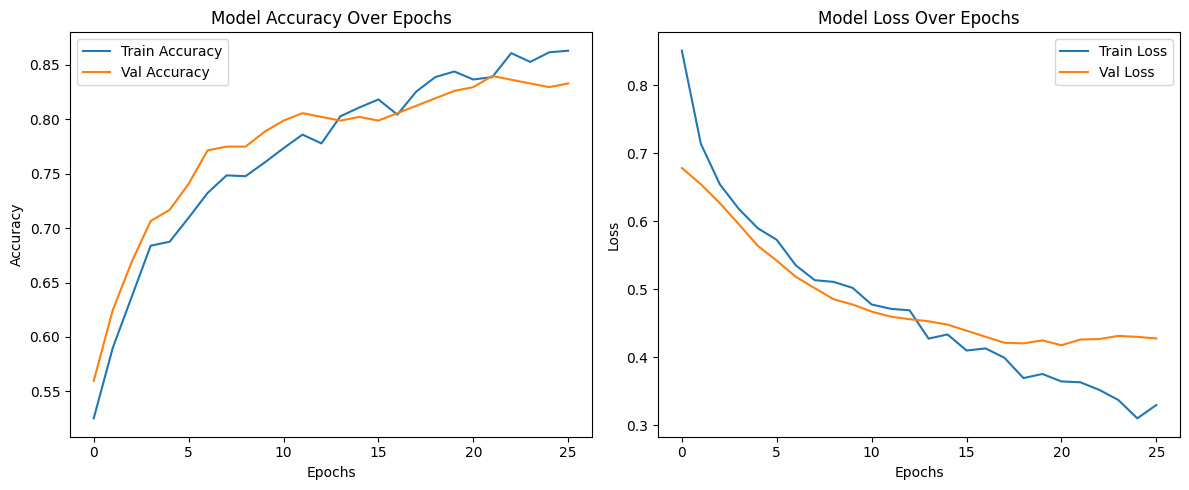

In [61]:
# --- Training History Visualization ---

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

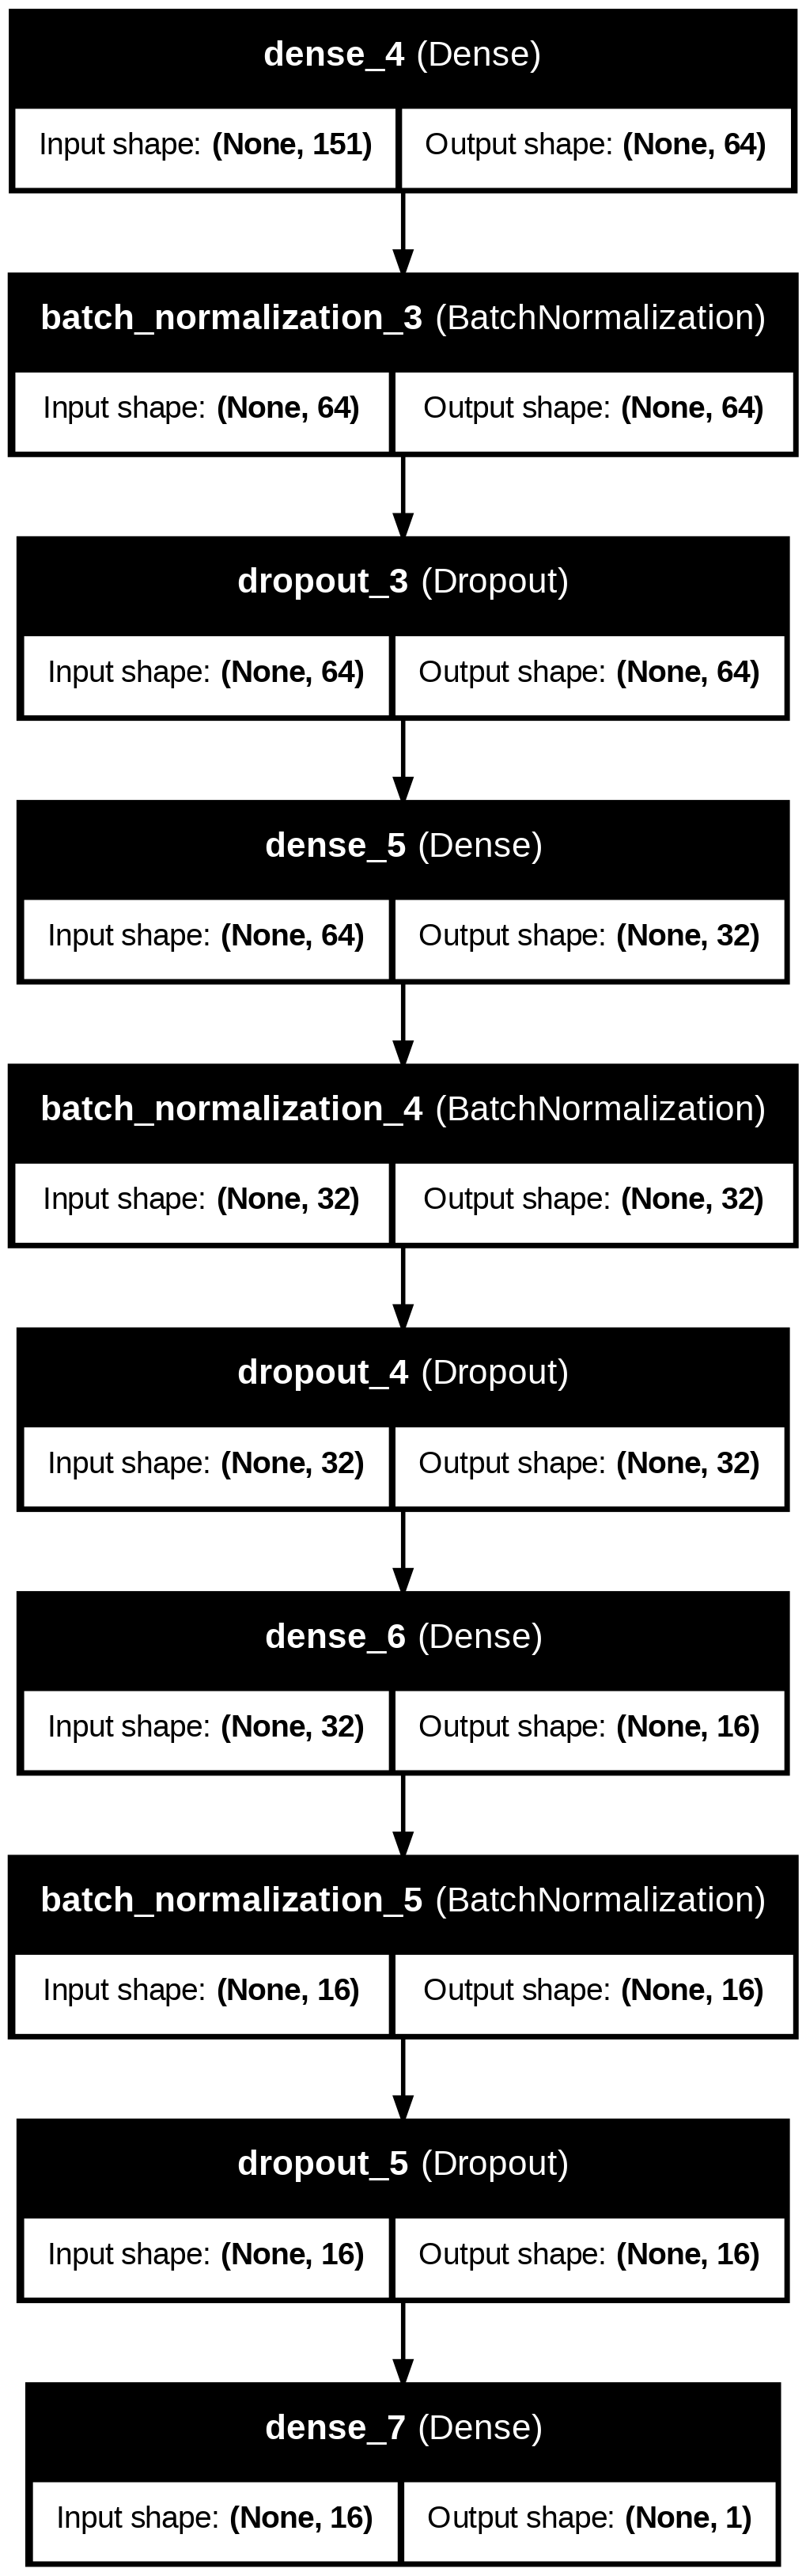

In [62]:
# print visual model summary
tf.keras.utils.plot_model(
    model,
    to_file='model_plot.png', # Save it as an image file
    show_shapes=True,
    show_layer_names=True
)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
              precision    recall  f1-score   support

           0       0.88      0.76      0.82       147
           1       0.79      0.90      0.84       146

    accuracy                           0.83       293
   macro avg       0.84      0.83      0.83       293
weighted avg       0.84      0.83      0.83       293



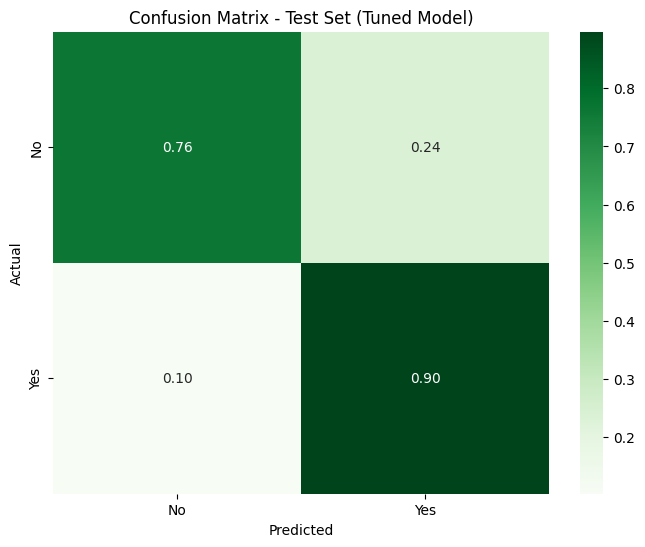

In [63]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities
y_pred_probs = model.predict(X_test_processed)

# Convert probabilities to binary (0/1)
y_pred = (y_pred_probs >= 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix for test set
cm = confusion_matrix(y_test, y_pred, normalize='true')
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix - Test Set (Tuned Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Neural Network Performance Summary


We implemented a feedforward neural network with three hidden layers (64 → 32 → 16), each followed by Batch Normalization and Dropout for stability and regularization. The model was trained with early stopping and a learning rate scheduler to prevent overfitting and optimize convergence.

## Performance on Test Set

* **Accuracy:** 83%
* **Precision:** 82%
* **Recall:** 85%
## Analysis & Conclusion

These results show that the neural network generalized well, with balanced precision and recall. Compared to the Random Forest, the NN performed slightly lower overall but demonstrated competitive results, especially in capturing true positives (higher recall). This suggests the NN was effective at identifying potential dropouts, though tree-based methods remained stronger in overall performance for this dataset size and can potentially improve with an increase in the size of the training dataset.

---
## Findings & Discussion

### Model Performance Summary
The **Random Forest (RF) model performed better** than the Neural Network (NN), achieving a final accuracy of **88%** on the test set, compared to the NN's **83%**.

The superior performance of the Random Forest is likely due to two main reasons:
* **Suitability for Tabular Data**: Tree-based models like Random Forest are often highly effective on structured, tabular datasets like the one used in this project.
* **Dataset Size**: With just under 2,000 samples, the dataset may have been too small for the Neural Network to effectively learn complex patterns and generalize, whereas the Random Forest can perform robustly on smaller datasets.

### Strengths & Limitations

#### Dataset
* **Strengths**:
    * The **UWIZA 2015 dataset** is a rich, real-world source of socio-economic data directly relevant to the problem of school dropout in Uganda.
    * It contains a diverse set of features covering individual, household, and environmental levels, providing a holistic view of a student's circumstances.

* **Limitations**:
    * **Age of Data**: The dataset is from 2015. Socio-economic conditions may have changed in the past decade, which could affect the model's performance on current data.
    * **Data Reduction**: The original dataset was imbalanced, and the team created a balanced subset of 1,948 records. While necessary, this approach discards a large amount of data from the majority class, which might have contained useful information.
    * **Feature Selection**: We selected 30 features from a possible 456, which was a necessary step but could have omitted potentially predictive variables.

#### Models
* **Strengths**:
    * The **Random Forest** model not only provided high accuracy but also delivered a clear and actionable **feature importance report**, identifying student age as the most critical predictor.
    * The implementation of two different model types (RF and NN) demonstrates strong technical breadth.
    * The use of **scikit-learn Pipelines**, proper train/validation/test splits, and robust evaluation metrics shows a methodologically sound process.

* **Limitations**:
    * The **Neural Network** was less effective, likely due to the small dataset size, and its "black box" nature makes it less interpretable than the Random Forest.
    * **Generalizability**: The models are trained specifically on 2015 Ugandan data. Their predictive power on data from other countries or more recent years is untested and likely to be lower.



# Citations
[Dropout statistics](https://muwado.com/confronting-the-school-dropout-dilemma-in-uganda/?v=2a0617accf8b#:~:text=In%20Uganda%20the%20school%20dropout,out%20before%20completing%20primary%20education.)

[Data Source](https://data.humdata.org/dataset/learning-levels-in-uganda-2015)

[ChatGPT Chat](https://chatgpt.com/share/68c5a0a6-aba8-8011-bd9b-001508b69a48)


